In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('paper')
sns.set_style('white')
# A helper function for downloading files
import requests
import os
def download(url, local_filename=None):
    """
    Downloads the file in the ``url`` and saves it in the current working directory.
    """
    data = requests.get(url)
    if local_filename is None:
        local_filename = os.path.basename(url)
    with open(local_filename, 'wb') as fd:
        fd.write(data.content)

# Lecture 27.1 - Probabilistic programming with `PyMC3` 

## Objectives

+ To introduce probabilistic programming as a flexible paradigm for data-driven inference.
+ Introduce `PyMC3` - a popular probabilistic programming library. 
+ Demonstrate key features of the `PyMC3` API and demonstrate it's use with some simple examples. 

**Note:** The first version of this notebook was compiled by [Dr. Rohit Tripathy](https://rohittripathy.netlify.app).

## Probabilistic programming and PyMC3 - very brief introduction

Probabilistic programming is a paradigm for:

1. easily translating abstract probabilistic models into executable software, and, 
2. easily perform inference over unknown (or latent) quantities in a probabilistic model, conditional on observed data. 

There are numerous probabilistic programming libraries (PPLs) in Python - the specific choice of PPL for an application is a matter of personal taste and comfort - all major PPLs have implementations of all standard inference algorithms and are very flexible in what kinds of probabilistic models can be setup. The most popular choices are `PyMC3`, `pyro`, and `tensorflow-probability`. 

The Python based PPL we will use, for this class, is `PyMC3`. `PyMC3` relies on `theano` for it's backend. `theano` is a numerical computing library (similar to `PyTorch` and `TensorFlow`) that has several neat features such as:
 + the ability to easily take derivatives of complex functions of `theano` variables without any hand computation or symbolic differentiation (i.e. automatic differentiation), 
 + internal optimizations to accelerate linear algebraic operations.
 + GPU support.

The original purpose of the `theano` library was to efficiently implement complex deep neural network architectures without worrying about gradient computations necessary for network optimization. While `theano` has gone out of fashion (and is no longer under active development, because of `PyTorch` and `TensorFlow`), the developers of `PyMC3` have ensured that the users of their library need minimal interactions with `theano` code so we will not worry too much about it. 
The reason modern PPLs such as `PyMC3` use backends such as `theano` is their automatic differentiation (AD) capabilities.
State-of-the-art inference methods such as the Hamiltonian Monte Carlo (or improved variants like No U-Turn Sampler (NUTS)), or black-box variational inference (BBVI) necessitate the computation of $\nabla_{\theta} p(\theta, \mathcal{D})$ - the gradient of a joint probability model with respect to the latent variables (or variational parameters in case of BBVI). This task can become very difficult for even moderately complex probabalistic models but if one leverages the AD capabilities of `theano`, one can obtain these gradients at a very low cost without writing any additional code.

### Quick recap of Bayesian inference 

The goal of Bayesian inference is to derive a probability distribution over unknown quantities, conditional on any observed data (i.e. a posterior distribution). 
Without loss of generality, let us denote the unknown quantities in a system as $\theta$ and the observed data as $\mathcal{D}$. 

We start with a description of our prior state of knowledge over $\theta$ - $p(\theta)$. We then specify a conditional probabilistic model that links the observed data with the unknown quantities $p(\mathcal{D}|\theta)$ (the likelihood). 
We want $p(\theta|\mathcal{D})$ which we know, from Bayes rule, to be:
$
p(\theta | \mathcal{D}) \propto p(\mathcal{D}, \theta).
$

PPL exist to - 1. set up $p(\mathcal{D}, \theta)$, and 2. estimate $p(\theta | \mathcal{D})$ in the most simple manner possible. Notice that we do not make ANY assumption on what form the priors or likelihoods should take (no need to try and fit conjugate models or setup simplistic models for ease of computation). 

## `PyMC3` - Quick tour

### 1. Setting up distributions 

Distributions in `PyMC3` are defined within `pymc3.distributions` and are exposed at the top of the library. To define a distribution, one simply needs to add a statement of the `pymc3.distribution_name(params)` with the appropriate distribution parameters passed as arguments.

For example, suppose we wish to define a Gaussian random variable with mean 1 and variance 2, i.e.,$x \sim \mathcal{N}(1, 2)$. `x` is defined in `PyMC3` as follows:

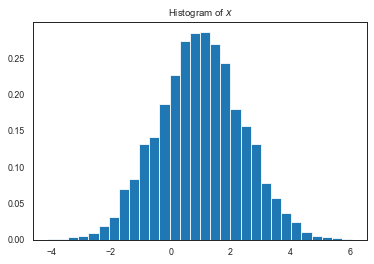

In [2]:
import pymc3 as pm

# define the context manager 
model = pm.Model()

# define the distribution 
with model:
    x = pm.Normal(name='x', mu=1., sigma=np.sqrt(2.)) 
    
# generate samples from x 
_=plt.hist(model.x.random(size=5000), bins=30, density=True)
_=plt.title('Histogram of $x$')

You can also define tensors, with arbitrary shapes, of i.i.d. samples from any given distribution. 

In [4]:
model = pm.Model()
with model:
    A = pm.Normal(name='A', mu=1., sigma=np.sqrt(2.), shape=3)
Asamples = model.A.random(size = 100)
print(Asamples.shape)

(100, 3)


Every `PyMC3` distribution is equipped with a `distribution.logp` function which computes the logarithm of the probability density (or mass) function of the distribution for a given input value. You can either compute the log probability as an elementwise operation or the sum of the log probability over all the elements.

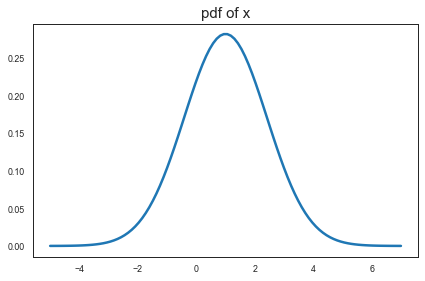

In [5]:
model = pm.Model()
with model:
    x = pm.Normal(name='x', mu=1., sigma=np.sqrt(2.))

xs = np.linspace(-5, 7, 100)
logpdfs = model.x.distribution.logp(xs).eval() # note the .eval() ; 
                                               #it converts a theano tensor 
                                               #into a numpy array 
    
plt.plot(xs, np.exp(logpdfs), linewidth=2.5)
_=plt.title('pdf of x', fontsize=15)
plt.tight_layout()

In [6]:
xsamples = 1 + np.sqrt(2.)*np.random.randn(50)  # generate 50 iid samples 
total_logprob = model.x.distribution.logp_sum(xsamples).eval()
print('The total log probability of all the samples is %.5f.'%total_logprob)

The total log probability of all the samples is -86.60515.


Note that all model specification in `PyMC3` must happen within the `pymc3.Model` context manager.

If this approach for computing the log probability feels complicated, do not worry - we will rarely (if ever) have to perform log probability explicitly when setting up inference models in `PyMC3` - the inference algorithms perform these computations under the hood for us.

### 2. Setting up a joint model -  the `pymc3.Model` context 

To reiterate a previous point, `PyMC3.Model` context serves as a wrapper for the entire probabilistic model in `PyMC3`. Let's re-visit a simple problem - the coin toss example, and demonstrate how to setup a probabilistic model in `PyMC3`. 

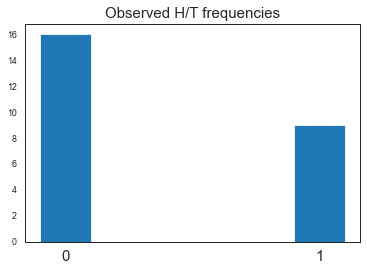

In [7]:
# data 
ptrue = 0.3  # prob of heads 
N = 25
data = np.random.binomial(1, ptrue, size=(N,))

# plot data 
_=plt.bar(*np.unique(data, return_counts=True), width=0.2)
_=plt.xticks([0, 1], fontsize=15)
_=plt.title('Observed H/T frequencies', fontsize = 15)

#### The coin toss model 

We observe data on repeated flipping of a coin with unknown probability of heads. 

Suppose the true probability of heads is $\theta$.

We do not know what $\theta$ really is, but we know it is somewhere in the interal $(0, 1)$. Let's be as vague about this as possible and assign equal probability density to all values in that interval, i.e., the prior is:
$$
\theta \sim \mathrm{Unif}([0, 1]).
$$

Each coin flip has a binary outcome - 1 (heads) or 0 (tails) and we can safely assume that each individual coin flip is independent of each other. 
Thus our likelihood model is:
$$
x_i|\theta \overset{\mathrm{i.i.d.}}{\sim} \mathrm{Bernoulli}(\theta).
$$

"Specifying" a probability model in a PPL means setting up a function for the joint distribution of latent and observed quantities - in this case,$p(\theta, \mathbf{x})$, where $\theta$ and $\mathbf{x} = (x_1, x_2, \dots, x_N)^T$. 
Here's the graphical description of this model:

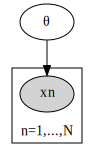

In [9]:
from graphviz import Digraph
gcp = Digraph('coin_toss_bayes_plate')
gcp.node('theta', label='<&theta;>')
with gcp.subgraph(name='cluster_0') as sg:
    sg.node('xn', label='<x<sub>n</sub>>', style='filled')
    sg.attr(label='n=1,...,N')
    sg.attr(labelloc='b')
gcp.edge('theta', 'xn')
gcp

And here's the `PyMC3` description of the model:

In [10]:
# instantiate a model context 
model = pm.Model()
theta_transform = pm.transforms.Interval(0, 1)

with model:
    # set up the prior 
    theta = pm.Uniform(name='theta', lower=0., upper=1.)
    
    # set up the likelihood 
    x = pm.Bernoulli(name='x', p=theta, observed=data)

    
print("Coin flip probability model:")
model

Coin flip probability model:


### 3.  Model variables in `PyMC3`

All unobserved (or latent) variables in a `pymc3` model are wrapped up into the user defined `model` context and exposed through the `model.vars` list. These are the variables over which inference is performed. 

In [11]:
latent_vars = model.vars
print(latent_vars)

[theta_interval__]


The coin flip model has only 1 latent variable, $\theta$. Notice that the `model.vars` list does not contain `theta` directly. Instead it contains a variable with the name `theta_interval__`. This is because, by default, variables that have finite suppport are passed through a bijective transformation to create a new variable that has support over the entire real line. 

For instance, $\theta$ in the coin flip example has support over the interval $(0, 1)$. For a variable constrained to lie within such the interval $[a, b]$, `pymc3` applies the transformation $g(x) = \log \frac{x - a}{b - x}$ ([see here](https://github.com/pymc-devs/pymc3/blob/683faaa9d7e58701f0689b1a1fd4080151f7e057/pymc3/distributions/transforms.py#L262)). 
The user-defined `model` context then adds the random variable $g(\theta)$ (rather than $\theta$ itself) to the `model.vars` list. 
In `PyMC3`, $g(\theta)$ is an instance of the `FreeRV` random variable class, i.e., it is a random variable that has support over entire $\mathbb{R}$. 
This automatic transformation is applied to make MCMC inference more efficient.

### 4. Maximum a posteriori estimation using `pymc3.find_map`

Once you have set up the model, you need one extra line to perform any kind of inference. The `pymc3.find_map` does exactly what the name suggests - it finds a point estimate of the latent variables by maximizing the joint probability model.

In [12]:
init_val = {'theta':0.5}  # starting point for optimization
res = pm.find_MAP(model=model, start=init_val, progressbar=True)

logp = -17.329, ||grad|| = 3.5: 100%|██████████| 7/7 [00:00<00:00, 1733.90it/s]


In [13]:
theta_MAP = res['theta']
print('True p(H): %.2f ; Estimated p(H): %.2f'%(ptrue, theta_MAP))

True p(H): 0.30 ; Estimated p(H): 0.36


### 5. Inference using `pymc3.sample`

Fully Bayesian inference is handled through the `pymc3.sample` interface, regardless of the inference technique, be it MCMC or VI.  
Let's infer the posterior over $\theta$ for this coin flip example. 

Note that you need to place the pm.sample within the context of the appropriate model.

In [17]:
with model:
    mcmc_res = pm.sample(draws = 10000, step=pm.NUTS())

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [00:12<00:00, 3270.84draws/s]


You can then use `pymc3.traceplot` for visualizing the estimated posterior over the latent variables. 

/Users/iliasbilionis/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/iliasbilionis/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/iliasbilionis/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/iliasbilionis/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has no

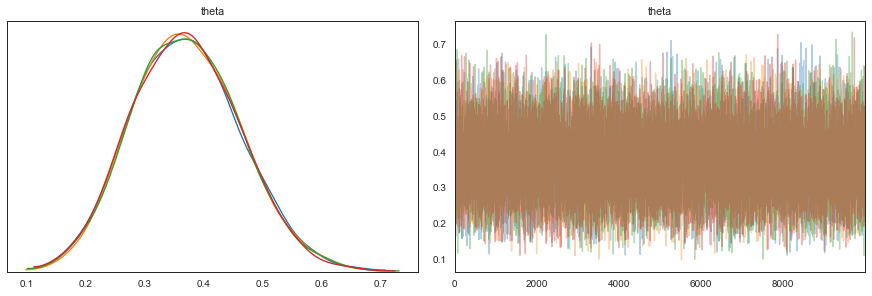

In [18]:
fig_args = {'figsize':(12, 4)}
pm.traceplot(mcmc_res, **fig_args);

You can get a quantitative summary of the posterior as a `pandas.DataFrame` object using `pymc3.summary`:

In [19]:
summary = pm.summary(mcmc_res)
summary

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta,0.371,0.091,0.203,0.544,0.001,0.001,15751.0,15751.0,15701.0,24281.0,1.0


In [20]:
np.percentile(mcmc_res.theta, [2.5, 50, 97.5])

array([0.20132597, 0.36842141, 0.55693392])

You can access the generated MCMC samples for any latent variable through the `mcmc_res` object. See for example:

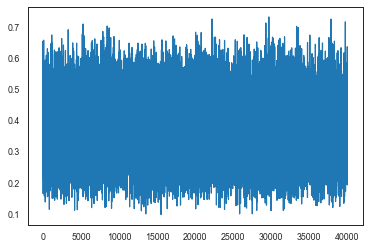

In [22]:
theta_mcmc_samples = mcmc_res.theta
plt.plot(theta_mcmc_samples);

### 6. Visualization utilities 

`PyMC3` has numerous utility functions for generating various standard visualizations after performing inference. We demonstrate a few common ones here. 

#### Plotting the posterior of the latent variables 

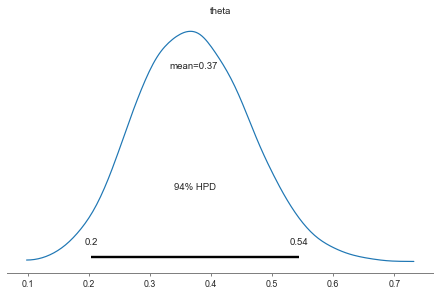

In [23]:
_=pm.plot_posterior(mcmc_res)   # just pass the mcmc trace to pm.plot_posterior

#### Autocorrelation plots 

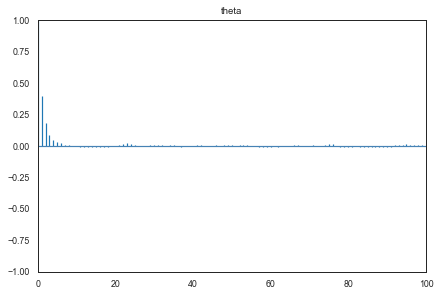

In [24]:
_=pm.plot_autocorr(mcmc_res, combined=True)   # just pass the mcmc trace to pm.plot_autocorr

For generating pair plots in models with more than 1 latent variables, you can use `pm.plot_pairs`.

### 7. Burning and thinning 

If you need to burn some initial samples or thin later samples to remove autocorrelation, you can simply apply standard numpy slicing operations.

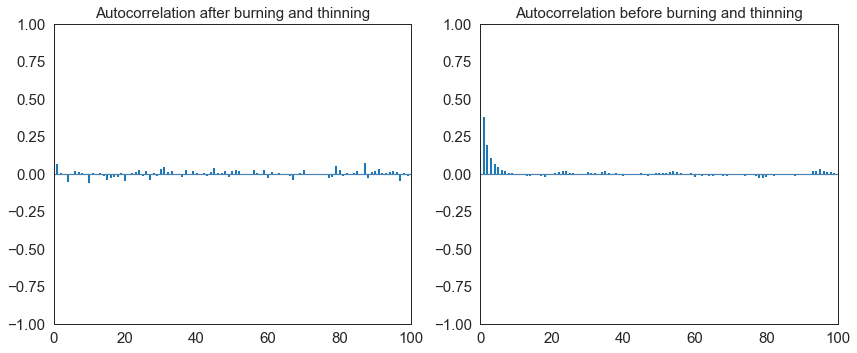

In [25]:
mcmc_res_burn_thin = mcmc_res[1000::4]  # remove the first 1000 samples and take every 4th sample after that 

fig,ax = plt.subplots(1, 2, figsize = (12, 5))
pm.autocorrplot(mcmc_res_burn_thin, ax=ax[0], textsize=15)   # this should almost no autocorrelation 
pm.autocorrplot(mcmc_res, ax=ax[1], textsize=15)
ax[0].set_title('Autocorrelation after burning and thinning', fontsize=15)
ax[1].set_title('Autocorrelation before burning and thinning', fontsize=15)
fig.tight_layout()

### Posterior predictive distribution

You can generate samples from the posterior predictive distribution, using the `pymc3.sample_posterior_predictive` functionality (see below).

In [26]:
pp_samples = pm.sample_posterior_predictive(trace=mcmc_res, samples=500, model=model)
x_post = pp_samples['x']
x_post.shape # num samples of theta \times size of the dataset 

/Users/iliasbilionis/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:00<00:00, 1694.63it/s]


(500, 25)

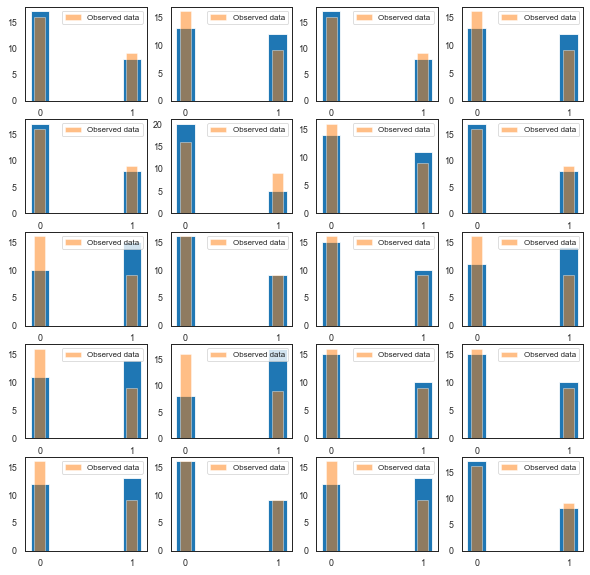

In [27]:
plt.figure( figsize=(10, 10) )
for i in range(20):
    plt.subplot(5, 4, i+1)
    plt.bar(*np.unique(x_post[i], return_counts=True), width=0.2)
    plt.bar(*np.unique(data, return_counts=True), width=0.12, 
            alpha=0.5, label='Observed data')
    plt.xticks([0, 1])
    plt.legend(loc='best', fontsize=8)

## Real Data Example 1 - Coal Mining Disaster 

We are going to work on Coal Mining disaster dataset. Consider the following time series dataset of recorded coal mining disasters in the UK from 1851 to 1962. Let us first import this dataset and visualize it.

In [30]:
import pandas as pd
disaster_data = pd.read_csv('coal_mining_disasters.csv')
disaster_data.dropna()
disasters = disaster_data.disasters.values
years = disaster_data.year.values
disaster_data

,year,disasters
0,1851,4
1,1852,5
2,1853,4
3,1854,0
4,1855,1
...,...,...
106,1957,0
107,1958,0
108,1959,1
109,1960,0


In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(disaster_data.year, disaster_data.disasters, 'o', markersize=10)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Number of disasters', fontsize=15)
plt.title('Recorded coal mining disasters in the UK.', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()

In [ ]:
plt.figure(figsize=(12, 8))
bp = plt.bar(disaster_data.year, disaster_data.disasters, width=1.)
plt.xlabel("Year", fontsize=15)
plt.ylabel("Number of disasters", fontsize=15)
plt.title("Recorded coal mining disasters in the UK.", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()

### 1. Questions

1. How can we represent this disaster time series data? What are quantities of interests?
2. Is 'disasters' variable categorial or continous? Can it be negative? What are some other constraints?

### 2. Information about the dataset 

Occurrences of disasters in the time series is thought to be derived from a Poisson process with a large rate parameter in the early part of the time series (more disasters in early years), and from one with a smaller rate in the later part (less number of disasters in later years). We are interested in locating the change point in the series, which might be because of changes in mining safety regulations in latter years.

### 3. Modeling Approach

How are we going to develop model for this data? A good starting point would be to think about *how this data might be generated?* Try to imagine how you would recreate the dataset. We begin by asking how our observations might have been generated [3].

1. We start by thinking "what is the best random variable to describe this count data?" A Poisson random variable is a good candidate because it can represent count data. So we model the number of coal mining related disasters as sampled from a Poisson distribution.

2. Next, we think, "Ok, assuming number of disasters are Poisson-distributed, what do I need for the Poisson distribution?" Well, the Poisson distribution has a rate parameter $\lambda$. 

3.  Do we know $\lambda$? No. In fact, we have a suspicion that there are *two* $\lambda$ values, one for the earlier years and one for the later years. We don't know when the change in this rate parameter occurs though, but call the switchpoint $\tau$.

4. What is a good distribution for the two $\lambda$s? The exponential is good, as it assigns probabilities to positive real numbers. Well the exponential distribution has a parameter too, call it $\alpha$.

5.  Do we know what the parameter $\alpha$ might be? No. At this point, we could continue and assign a distribution to $\alpha$, but it's better to stop once we reach a set level of ignorance: whereas we have a prior belief about $\lambda$, ("it probably changes over time", "it's likely between 1 and 3", etc.), we don't really have any strong beliefs about $\alpha$. So it's best to stop here. 

    What is a good value for $\alpha$ then? We think that the $\lambda$s are between 1-3, so if we set $\alpha$ really low (which corresponds to larger probability on high values) we are not reflecting our prior well. Similar, a too-high alpha misses our prior belief as well. A good idea for $\alpha$ as to reflect our belief is to set the value so that the mean of $\lambda$, given $\alpha$, is equal to our observed mean. 

6. We have no expert opinion of when $\tau$ might have occurred. So we will suppose $\tau$ is from a discrete uniform distribution over the entire timespan.

Here's a graphical model describing the relationships between the variables in our model:

In [ ]:
gcp = Digraph('coal_mining_disasters_model')

# define the nodes 
gcp.node('alpha', label='<&alpha;>')
gcp.node('tau', label='<&tau;>')
gcp.node('lambda_1', label='<&lambda;<sub>1</sub>>')
gcp.node('lambda_2', label='<&lambda;<sub>2</sub>>')
gcp.node('lambda', label='<&lambda;>')
gcp.node('tau', label='<&tau;>')
gcp.node('obs', label='obs', style='filled')

# define the edges 
gcp.edge('alpha', 'lambda_1')
gcp.edge('alpha', 'lambda_2')
gcp.edge('tau', 'lambda')
gcp.edge('lambda_1', 'lambda')
gcp.edge('lambda_2', 'lambda')
gcp.edge('lambda', 'obs')
gcp

More formally, the generative model is expressed as:

$$\lambda_1 \sim \mathrm{Exp}(\lambda_1 | \alpha),$$
$$\lambda_2 \sim \mathrm{Exp}(\lambda_2 | \alpha),$$
$$ \tau \sim \mathrm{DiscreteUniform}([1851, 1852, \dots, 1961]), $$
$$\lambda = 
\begin{cases}
\lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}$$
$$\mathrm{obs}_i \sim \mathrm{Poisson}(\lambda_i)$$

We will set the rate parameter $\alpha$ on the exponential priors on $\lambda_1$ and $\lambda_2$ as a constant. 
The latent variables to be inferred are $\lambda_1, \lambda_2, \tau$.

### 4. `PyMC3` model 

In [ ]:
disaster_model = pm.Model()
lower_year, upper_year = years.min(), years.max()
alpha = 1.

with disaster_model:
    # define the prior 
    lambda_1 = pm.Exponential("lambda_1", lam=alpha)
    lambda_2 = pm.Exponential("lambda_2", lam=alpha)
    tau      = pm.DiscreteUniform('tau', lower=lower_year, upper=upper_year)
    lmbda = pm.Deterministic('lambda', tt.switch(tau >= years, lambda_1, lambda_2))
    
    # define the likelihood 
    x = pm.Poisson('x', lmbda, observed=disasters)

### 5. Inference and posterior visualization

Now let's infer the hidden parameters with MCMC. We will use the default NUTS sampler. 

In [ ]:
with disaster_model:
    trace = pm.sample(draws=40000, progressbar=True)

In [ ]:
_=pm.traceplot(trace, var_names=['tau', 'lambda_1', 'lambda_2'])

In [ ]:
_=pm.plot_posterior(trace, var_names=['tau', 'lambda_1', 'lambda_2'])

In [ ]:
_=pm.plot_autocorr(trace, var_names=['tau','lambda_1', 'lambda_2'], combined=True)

In [ ]:
thinned_trace = trace[10000::10]
_=pm.plot_autocorr(thinned_trace, var_names=['tau', 'lambda_1', 'lambda_2'], combined=True)

In [ ]:
pm.traceplot(thinned_trace, var_names=['tau', 'lambda_1', 'lambda_2'])

We can now use the samples from the posterior of the unknown parameters in this model to estimate the expected number of disasters between $t = 1851$ and $t=1962$. 

In [ ]:
ppsamples = pm.sample_posterior_predictive(samples=2000, 
                                           model=disaster_model, 
                                           trace=thinned_trace)['x']
plt.figure(figsize=(12, 8))
bp = plt.bar(disaster_data.year, disaster_data.disasters, width=1.)
plt.plot(disaster_data.year, ppsamples.mean(axis=0), 'ro', 
         markersize=10, label='Posterior predictive expectation')
plt.xlabel("Year", fontsize=15)
plt.ylabel("Number of disasters", fontsize=15)
plt.title("Recorded coal mining disasters in the UK.", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='best', fontsize=15)
plt.tight_layout()

## Real Data Example 2 - Challenger Space Shuttle Disaster

For this tutorial, we are going to work on Challenger space shuttle disaster dataset. 

On January 28, 1986, the twenty-fifth flight of the U.S. space shuttle program ended in disaster when one of the rocket boosters of the Shuttle Challenger exploded shortly after lift-off, killing all seven crew members. The presidential commission on the accident concluded that it was caused by the failure of an O-ring in a field joint on the rocket booster, and that this failure was due to a faulty design that made the O-ring unacceptably sensitive to a number of factors including outside temperature. Of the previous 24 flights, data were available on failures of O-rings on 23, (one was lost at sea), and these data were discussed on the evening preceding the Challenger launch, but unfortunately only the data corresponding to the 7 flights on which there was a damage incident were considered important and these were thought to show no obvious trend. The data are shown below:

In [ ]:
# load data 
challenger_data = np.genfromtxt("challenger_data.csv", skip_header=1,
                                usecols=[1, 2], missing_values="NA",
                                delimiter=",")
challenger_data = challenger_data[~np.isnan(challenger_data[:, 1])]
print("Temp (F), O-Ring failure?")
print(challenger_data)

In [ ]:
# plot it, as a function of temperature (the first column)
plt.figure(figsize=(12, 5))
plt.plot(challenger_data[:, 0], challenger_data[:, 1], 'ro', 
         markersize=15)
plt.ylabel("Damage Incident?",fontsize=20)
plt.xlabel("Outside temperature (Fahrenheit)",fontsize=20)
plt.title("Defects of the Space Shuttle O-Rings vs temperature",
          fontsize=20)
plt.yticks([0, 1], fontsize=15)
plt.xticks(fontsize=15)
plt.tight_layout()

### 1. Information about the dataset 
It looks clear that *the probability* of damage incidents occurring increases as the outside temperature decreases. We are interested in modeling the probability here because it does not look like there is a strict cutoff point between temperature and a damage incident occurring. The best we can do is ask "At temperature $t$, what is the probability of a damage incident?". The goal of this example is to answer that question.

### 2. Questions

1. How can we represent this disaster binary 1/0 data? What are quantities of interests?
2. Is 'damage incident' variable categorial or continous? What are some other constraints?

### 3. Modeling approach

How are we going to develop model for this data? A good starting point would be to think about *how this data might be generated?* Try to imagine how you would recreate the dataset. We begin by asking how our observations might have been generated.

- We start by thinking "what is the best random variable to describe this binary categorical data?" A Bernoulli random variable is a good candidate because it can represent binary data. So we model the variable of 'damage incident' as sampled from a Bernoulli distribution. A *Bernoulli* random variable with parameter $p$, denoted $\text{Ber}(p)$, is a random variable that takes value 1 with probability $p$, and 0 else. Thus, our model can look like:
$$ \text{Defect Incident, $D_i$} \sim \text{Ber}( \;p_i\; ), \;\; i=1..N$$

- Next, we think, "Ok, assuming damage incident variable is Bernoulli-distributed, what do I need for the Bernoulli distribution?" Well, the Bernoulli distribution has a probability parameter $p_i$. 

-  Do we know $p_i$ parameter? No. But we have a suspicion (intuition) that this parameter is dependent on outside temperature values. Less the value of outside temperature, more is the probability of damage incident. More the value of outside temperature, less is the probability of damage incident. With slight abuse in notation, we can define this as:
$$p_i = p(t_i) = \sigma(t_i),$$

where $\sigma: \mathbb{R} \rightarrow (0, 1)$ is a suitable function that maps arbitrary temperature values to the interval $(0, 1)$ (so that we can then interpret the output of $\sigma$ as a probability). For this problem, we are going to use logistic link function which is given as:
$$\sigma(t) = \frac{1}{ 1 + e^{ \;\beta t + \alpha } } $$

Some plots are shown below, with differing $\alpha$ and $\beta$ parameter values:

In [ ]:
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

x = np.linspace(-4, 4, 100)
plt.figure(figsize=(12, 5))
alphas = [0, 0, 0, 1, 3, 5]
betas  = [1, 3, -5, 1, 3, -5]
params = zip(alphas, betas)
for param in params:
    alpha, beta = param
    label="$\\alpha$ = %d, $\\beta$ = %d"%(alpha, beta)
    plt.plot(x, logistic(x, beta, alpha),
             label=label, 
             linewidth=2.5)
plt.title("Logistic functon with bias", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc="best", fontsize=15)
_=plt.tight_layout()

#### Question:
__How can we represent  $\alpha$ and $\beta$ parameter values? Are they categorical or continous? Do they need to be positive?__

The $\beta, \alpha$ parameters have no reason to be positive, bounded or relatively large, so they are best modeled by a *Normal random variable*. Since we dont have any prior beliefs about the value of parameters beta or alpha, we place a vague prior Normal distribution (small precision, large variance) over their values.

The graphical model for the data generation process is shown below. 

In [ ]:
gcp = Digraph('space_shuttle_disaster')

# setup the nodes 
gcp.node('alpha', label='<&alpha;>')
gcp.node('beta', label='<&beta;>')
with gcp.subgraph(name='cluster_0') as sg:
    sg.node('pi', label='<p<sub>i</sub>>')
    sg.node('xi', label='<x<sub>i</sub>>', style='filled')
    sg.attr(color='blue')
    sg.attr(label='i=1,2...')
    sg.attr(labelloc='b')

# setup the edges 
gcp.edge('alpha', 'pi')
gcp.edge('beta', 'pi')
gcp.edge('pi', 'xi')
gcp

### 4. `PyMC3` model 

In [ ]:
# gather the data and apply preprocessing if any 
temp = challenger_data[:, 0]
temp_scaled = (temp - np.mean(temp))/np.std(temp)
data = challenger_data[:, 1]

# instantiate the pymc3 model
challenger_model = pm.Model()

# define the graph 
with challenger_model:
    # define the prior
    alpha = pm.Normal('alpha', mu=0., sigma=10.)
    beta = pm.Normal('beta', mu=0., sigma=10.)
    
    # get the probabilities of failure at each observed temp 
    p = pm.Deterministic('p', 1./(1. + tt.exp(alpha + beta*temp_scaled)))
    
    # define the likelihood 
    x = pm.Bernoulli('x', p=p, observed=data)
print("Challenger space shuttle disaster model:")
challenger_model

### 5. Inference and posterior visualization

Now let's infer the hidden parameters with MCMC. We will use the default NUTS sampler. 

In [ ]:
with challenger_model:
    trace = pm.sample(draws=40000, progressbar=True)

In [ ]:
var_names=['alpha', 'beta']
pm.traceplot(trace, var_names=var_names)

In [ ]:
_=pm.plot_posterior(trace, var_names=var_names)

In [ ]:
_=pm.plot_autocorr(trace, var_names=var_names, figsize=(12, 8), combined=True)

In [ ]:
thinned_trace = trace[10000::10]
_=pm.autocorrplot(thinned_trace, var_names=var_names, figsize=(12, 8), combined=True)

### 6. Posterior predictive distribution

We can use the samples of posterior generated from MCMC to get a predictive over the probability of failure at any given temperature. 

In [ ]:
with challenger_model:
    ppsamples = pm.sample_posterior_predictive(trace=thinned_trace, 
                                               samples=2000,
                                               var_names=['p'])['p']

In [ ]:
# get posterior predictive mean and 95% interval
ppmean = ppsamples.mean(axis=0)
pp_lower, pp_upper = np.percentile(ppsamples, axis=0, q=[2.5, 97.5])

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(temp, data, 'ro', markersize=12, label='Observed data')
idx=np.argsort(temp)
plt.plot(temp[idx], ppmean[idx], linestyle='--', linewidth=2.5, 
         label='Post. pred. mean prob.')
plt.fill_between(temp[idx], pp_lower[idx], pp_upper[idx], 
                color='purple', alpha=0.25, label='95% Confidence')
plt.ylabel("Probability estimate",fontsize=20)
plt.xlabel("Outside temperature (Fahrenheit)",fontsize=20)
plt.title("Defects of the Space Shuttle O-Rings vs temperature",
          fontsize=20)
plt.yticks(np.arange(0., 1.01, 0.2), fontsize=20)
plt.xticks(fontsize=20)
plt.legend(loc='best', fontsize=20)
plt.tight_layout()

The *95% credible interval*, or 95% CI, painted in purple, represents the interval, for each temperature, that contains 95% of the distribution. For example, at 65 degrees, we can be 95% sure that the probability of defect lies between 0.25 and 0.75.

More generally, we can see that as the temperature nears 60 degrees, the CI's spread out quickly. As we pass 70 degrees, the CI's tighten again. This can give us insight about how to proceed next: we should probably test more O-rings around 60-65 temperature to get a better estimate of probabilities in that range. Similarly, when reporting to scientists your estimates, you should be very cautious about simply telling them the expected probability, as we can see this does not reflect how *wide* the posterior distribution is.

### 7. Question

On the day of the Challenger disaster, the outside temperature was 31 degrees Fahrenheit. What is the posterior distribution of a defect occurring,  given this temperature? The distribution is plotted below. It looks almost guaranteed that the Challenger was going to be subject to defective O-rings.